# Guide

## Quick-start
Let's import our package and define two small lists that we would like to compare in similarity

In [1]:
from polyfuzz import PolyFuzz

from_list = ["apple", "apples", "appl", "recal", "house", "similarity"]
to_list = ["apple", "apples", "mouse"]

Then, we instantiate our PolyFuzz model and choose `TF-IDF` as our similarity measure. We matche the two lists and 
check the results.

**NOTE**: We can also use `EditDistance` and `Embeddings` as our matchers. 

In [2]:
model = PolyFuzz("TF-IDF").match(from_list, to_list)
model.get_matches()

,From,To,Similarity
0,apple,apple,1.000000
1,apples,apples,1.000000
2,appl,apple,0.783751
3,recal,None,0.000000
4,house,mouse,0.587927
5,similarity,None,0.000000


As expected, we can see high similarity between the `apple` words. Moreover, we could not find a single match for `similarity` which is why it is mapped to `None`. 

#### Precision Recall Curve
Next, we would like to see how well our model is doing on our data. Although this method is unsupervised, we can use the similarity score as a proxy for the accuracy of our model (assuming we trust that similarity score).

A minimum similarity score might be used to identify when a match could be considered to be correct. For example, we can assume that if a similarity score pass 0.95 we are quite confident that the matches are correct. This minimum similarity score can be defined as **`Precision`** since it shows you how precise we believe the matches are at a minimum.

**`Recall`** can then be defined as as the percentage of matches found at a certain minimum similarity score. A high recall means that for a certain minimum precision score, we find many matches.

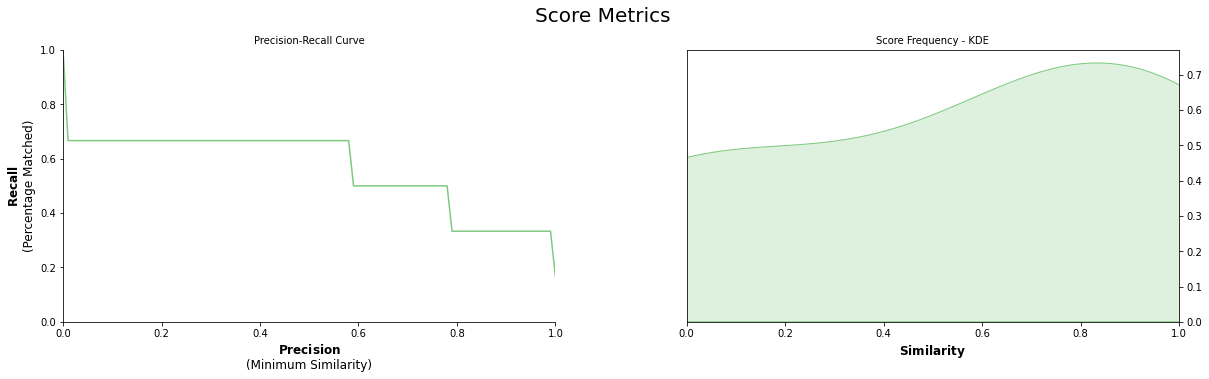

In [3]:
model.visualize_precision_recall(kde=True)

#### Group Matches
We can group the matches `To` as there might be significant overlap in strings in our `from_list`. 
To do this, we calculate the similarity within strings in `from_list` and use single linkage to then group the strings with a high similarity. 

In [4]:
model.group(link_min_similarity=0.75)
model.get_matches()

,From,To,Similarity,Group
0,apple,apple,1.000000,apples
1,apples,apples,1.000000,apples
2,appl,apple,0.783751,apples
3,recal,None,0.000000,None
4,house,mouse,0.587927,mouse
5,similarity,None,0.000000,None


As can be seen above, we grouped `apple` and `apples` together to `apple` such that when a string is mapped to `apple` it will fall in the cluster of [`apples`, `apple`] and will be mapped to the first instance in the cluster which is `apples`. 

For example, `appl` is mapped to `apple` and since `apple` falls into the cluster [`apples`, `apple`], `appl` will be mapped to `apples`. 

## Multiple Models

You might be interested in running multiple models with different matchers and different parameters in order to compare the best results.   
Fortunately, **`PolyFuzz`** allows you to exactly do this!

Below, you will find all models currently implemented in PolyFuzz and are compared against one another. 

In [6]:
from polyfuzz.models import EditDistance, TFIDF, Embeddings, RapidFuzz
from polyfuzz import PolyFuzz

from jellyfish import jaro_winkler_similarity
from flair.embeddings import TransformerWordEmbeddings, WordEmbeddings

from_list = ["apple", "apples", "appl", "recal", "house", "similarity"]
to_list = ["apple", "apples", "mouse"]

# BERT
bert = TransformerWordEmbeddings('bert-base-multilingual-cased')  # https://huggingface.co/transformers/pretrained_models.html
bert_matcher = Embeddings(bert, model_id="BERT", min_similarity=0)

# FastText
fasttext = WordEmbeddings('en-crawl')
fasttext_matcher = Embeddings(fasttext, min_similarity=0)

# TF-IDF
tfidf_matcher = TFIDF(n_gram_range=(3, 3), min_similarity=0, model_id="TF-IDF")
tfidf_large_matcher = TFIDF(n_gram_range=(3, 6), min_similarity=0)

# Edit Distance models with custom distance function
base_edit_matcher = EditDistance(n_jobs=1)
jellyfish_matcher = EditDistance(n_jobs=1, scorer=jaro_winkler_similarity)

# Edit distance with RapidFuzz --> slightly faster implementation than Edit Distance
rapidfuzz_matcher = RapidFuzz(n_jobs=1)

matchers = [bert_matcher, fasttext_matcher, tfidf_matcher, tfidf_large_matcher,
            base_edit_matcher, jellyfish_matcher, rapidfuzz_matcher]

In [7]:
model = PolyFuzz(matchers).match(from_list, to_list)

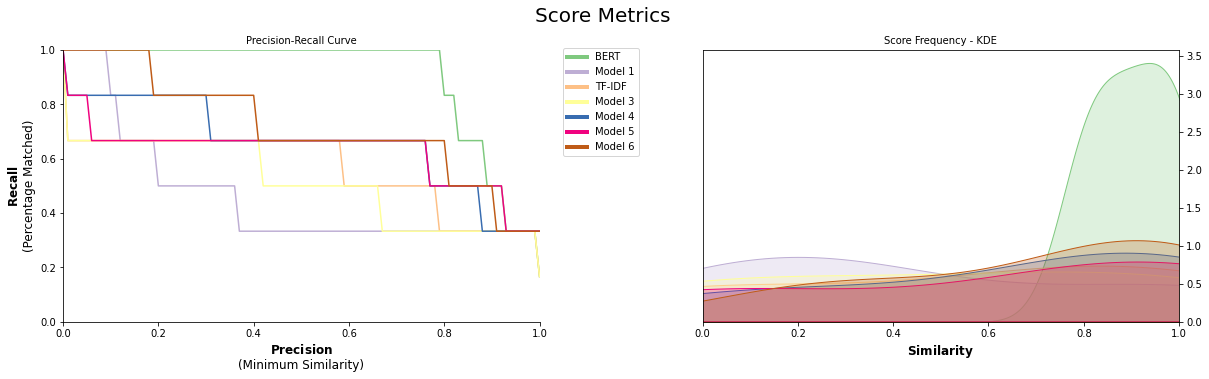

In [8]:
model.visualize_precision_recall(kde=True)

#### Custom Grouper

We can even use one of the `polyfuzz.models` to be used as the grouper in case you would like to use something else than the standard `TF-IDF` matcher:

In [9]:
base_edit_grouper = EditDistance(n_jobs=1)
model.group(base_edit_grouper)
model.get_matches("Model 1")

,From,To,Similarity,Group
0,apple,apple,1.000000,apples
1,apples,apples,1.000000,apples
2,appl,apple,0.367888,apples
3,recal,apple,0.119738,apples
4,house,mouse,0.195526,mouse
5,similarity,mouse,0.091616,mouse


In [10]:
model.get_clusters("Model 1")

{0: ['apples', 'apple']}

## Custom Models

Although the options above are a great solution for comparing different models, what if you have developed your own? What if you want a different similarity/distance measure that is not defined in PolyFuzz? That is where custom models come in. If you follow the structure of PolyFuzz's `BaseMatcher` you can quickly implement any model you would like. 

Below, we are implementing the `ratio` similarity measure from `RapidFuzz`. 

In [11]:
import numpy as np
import pandas as pd
from rapidfuzz import fuzz
from polyfuzz.models import EditDistance, TFIDF, Embeddings, BaseMatcher


class MyModel(BaseMatcher):
    def match(self, from_list, to_list):
        # Calculate distances
        matches = [[fuzz.ratio(from_string, to_string) / 100 for to_string in to_list] for from_string in from_list]
        
        # Get best matches
        mappings = [to_list[index] for index in np.argmax(matches, axis=1)]
        scores = np.max(matches, axis=1)
        
        # Prepare dataframe
        matches = pd.DataFrame({'From': from_list,'To': mappings, 'Similarity': scores})
        return matches

It is important that the `match` function takes in two lists of strings and throws out a pandas dataframe with three columns:
* From
* To
* Similarity

Then, we can simply create an instance of `MyModel` and pass it through `PolyFuzz`:

In [12]:
from_list = ["apple", "apples", "appl", "recal", "house", "similarity"]
to_list = ["apple", "apples", "mouse"]

custom_matcher = MyModel()

model = PolyFuzz(custom_matcher).match(from_list, to_list)

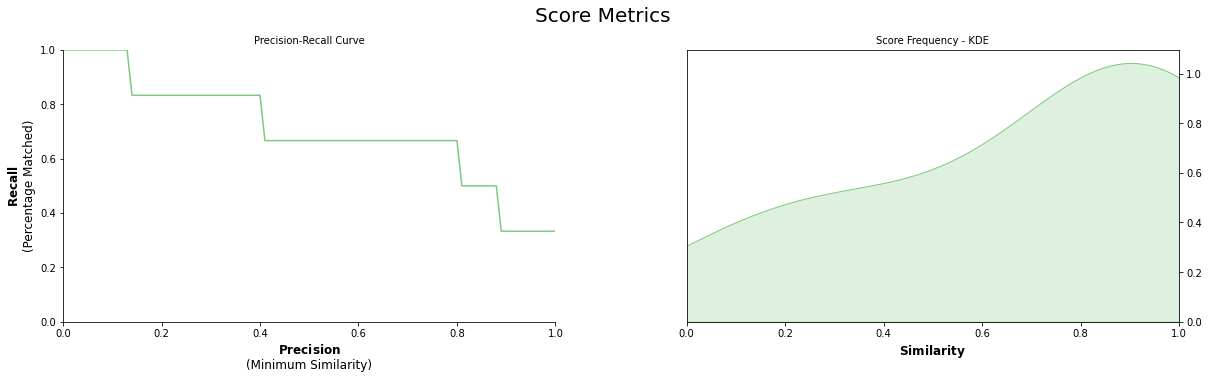

In [13]:
model.visualize_precision_recall(kde=True)